# Getting Started

## Requirements

* downloaded data and checkpoint files with `bash download.sh`
* a python environment with all dependencies installed

## Load required packages

In [1]:
import sys
sys.path.append("src")

import torch
from utils.dataset import ijgiDataset as Dataset
from models.sequenceencoder import LSTMSequentialEncoder
from utils.snapshot import resume
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np

## Initialize network and load pretrained weights

The network is now initialized with the pre-trained models and can be used to infer data

In [3]:
network = LSTMSequentialEncoder(48,48,nclasses=18)

if torch.cuda.is_available():
    network = torch.nn.DataParallel(network).cuda()

snapshot = torch.load("checkpoints/model_00.pth")
model_state = snapshot.pop('model_state', snapshot)

network.load_state_dict(model_state)

## Visualize some network weights

### Convolutional kernels

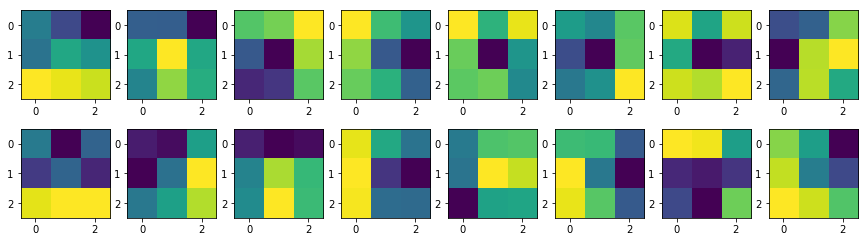

In [4]:
%matplotlib inline

f, axs = plt.subplots(2,8,figsize=(15,4))
for i in range(16):
    axs.reshape(-1)[i].imshow(model_state["module.inconv.weight"][i,0,0])

## Recurrent Weights

Split in 64x64 blocks for forget, input, modulation and output gates (left to right) for input (top row) and output (bottom row)

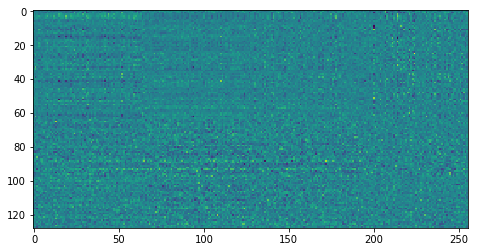

In [7]:
f, axs = plt.subplots(1,1,figsize=(15,4))
axs.imshow(model_state["module.cell.conv.weight"].permute(1, 0, 2, 3)[:,:,1,1])

## Load dataset and dataloader

This sets up an iterator that can be sequentially called using `next()`

In [8]:
dataset = Dataset("data", tileids="tileids/test_fold0.tileids")
dataloader = torch.utils.data.DataLoader(dataset,batch_size=1,shuffle=False,num_workers=0)
iterator = iter(dataloader)

[===========================             ] 1381/2016 ( 68%)  635 to go

rejected_nopath:784, rejected_length:19, total_samples:1213


[========================================] 2016/2016 (100%)    0 to go


## Get next item from the Iterator

run this cell multiple times for more data

In [9]:
# get single batch
data,label = next(iterator)

## Look at the Input Sentinel 2 data

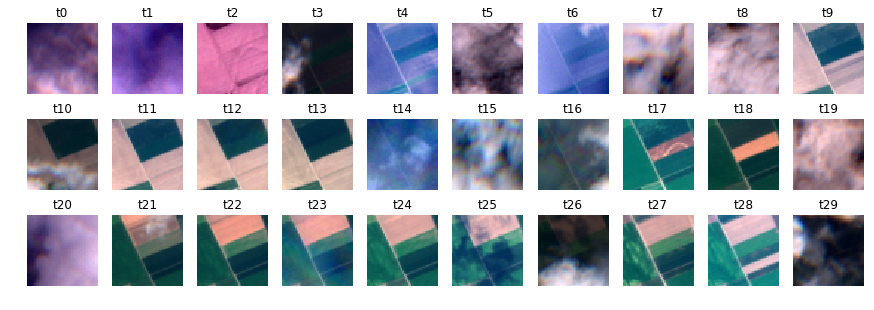

In [10]:
f, axs = plt.subplots(3,10,figsize=(15,5))

for i in range(30):
    img = data[0,i,0:3].permute(1,2,0)
    img = ((img-img.min())/(img-img.min()).max()) # normalize
    ax = axs.reshape(-1)[i]
    ax.set_axis_off()
    ax.imshow(img)
    ax.set_title("t"+str(i))

## Predict classes using the model

call the `.forward()` function to infer the data

In [11]:
activations = network.forward(data)
activations = activations.cpu().detach().numpy()

## Output class activations

Softmaxed class activations sum to one and can be interpreted as confidences of the network for one specific class 

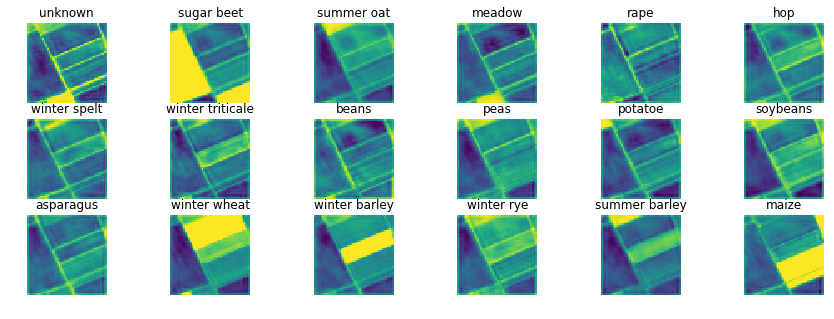

In [12]:
f, axs = plt.subplots(3,6,figsize=(15,5))
for i in range(18):
    ax = axs.reshape(-1)[i]
    ax.imshow(activations[0,i])
    ax.set_axis_off()
    ax.set_title(dataset.classes[i])

## Compare Ground Truth with Prediction

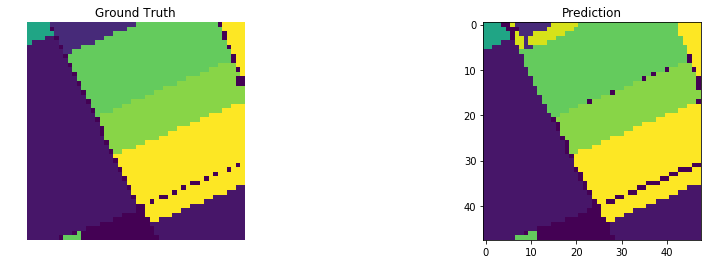

In [13]:
f, axs = plt.subplots(1,2,figsize=(15,4))
axs[0].imshow(torch.squeeze(label)); axs[0].set_title("Ground Truth"); axs[0].set_axis_off()
axs[1].imshow(np.argmax(activations[0],axis=0)); axs[1].set_title("Prediction"); axs[0].set_axis_off()